In [ ]:
import time

import numpy as np
import pandas as pd
from icecream import ic
from matplotlib import pyplot as plt
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    RepeatedKFold,
    train_test_split,
)
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

# DATA 607 - Machine Learning

## Class 7 &mdash; 2025.05.14

### Data, Model, Loss

- We're given a dataset $\{(x_i, y_i): i < n\}$.

- We want to build models $F$ for $\mathbb{E}[y\mid x]$.

- Let $L(F)$ be the ***training loss*** associated to $F$.
  - When $y$ is continuous and scalar, $L(F)$ could be ***mean-squared error***:
    $$
    L(F) = \frac1n\sum_i(y_i - F(x_i))^2
    $$
  - When $y$ is binary, $L(F)$ could be ***log-loss***:
    $$
    L(F) = -\frac1n\sum_i\Big\{ y_i\log F(x_i) + (1 - y_i)\log(1 - F(x_i))\Big\}
    $$

### Incremental improvement

- Suppose we've fit a model $F_0$ to the training data. How might we improve it (***boost*** its performance)?

- For ***small adjustments*** $h$,
  $$
  L(F_0 + h) \approx L(F_0) + \left.\frac{\partial L}{\partial F}\right|_{F=F_0}h.
  $$

  - This is ***calculus***; more precisely, ***first-order approximation***.

  - $\displaystyle \left.\frac{\partial L}{\partial F}\right|_{F=F_0}$ is called ***the gradient of $L$ at $F=F_0$***.

- If $\varepsilon$ is a sufficiently small positive number and we set
  $$
  h = -\varepsilon \left.\frac{\partial L}{\partial F}\right|_{F=F_0},
  $$
  then $h$ is a small adjustment, in which case
  $$
  L(F_0 + h) \approx L(F_0)  -\varepsilon \left(\left.\frac{\partial L}{\partial F}\right|_{F=F_0}\right)^2 < L(F_0).
  $$

- Thus, $F_1=F_0 + h$ has smaller training loss that $F_0$.

- Decreasing training loss by adjusting a model along the negative gradient of the loss is called ***gradient descent***.

$$
L(F) = \frac1n\sum_{i<n} (y_i - F(x_i))^2
$$

$$
\frac{\partial L}{\partial F} = \frac2n\sum_{i<n}(y_i - F(x_i))
$$

If $h(x)$ is some function approximating the residuals:
$$
h(x_i) \approx y_i - F(x_i)
$$

L(F + h)

In [ ]:
df = pd.read_csv("~/.kaggle/data/fashionmnist/fashion-mnist_train.csv")
y = df["label"]
X = df.iloc[:, 1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
ic(len(X_train), len(X_test))

In [13]:
model = RandomForestClassifier(
    n_estimators=200, max_features="sqrt", max_samples=20_000, n_jobs=-1
)
scores = cross_val_score(model, X_train, y_train, scoring="accuracy")
ic(scores.mean(), scores.std())

ic| scores.mean(): np.float64(0.8765416666666667)
    scores.std(): np.float64(0.0014766704288890987)


(np.float64(0.8765416666666667), np.float64(0.0014766704288890987))

In [14]:
model = RandomForestClassifier(
    n_estimators=200, max_features="sqrt", max_samples=20_000
)
scores = cross_val_score(model, X_train, y_train, scoring="accuracy")
ic(scores.mean(), scores.std())

ic| scores.mean(): np.float64(0.8767083333333332)
    scores.std(): np.float64(0.002424735094351086)


(np.float64(0.8767083333333332), np.float64(0.002424735094351086))

In [18]:
model = RandomForestClassifier(
    n_estimators=200, max_features="sqrt", max_samples=20_000, n_jobs=-1
)
model.fit(X_train, y_train)

RandomForestClassifier(max_samples=20000, n_estimators=200, n_jobs=-1)

In [29]:
from collections import Counter

tree = model.estimators_[0].tree_
ic(tree.node_count)

leaf_mask = tree.children_left < 0
ic(sum(leaf_mask))

Counter(tree.n_node_samples[leaf_mask])

ic| tree.node_count: 4423
ic| sum(leaf_mask): np.int64(2212)


Counter({np.int64(1): 1073,
         np.int64(2): 357,
         np.int64(3): 195,
         np.int64(4): 125,
         np.int64(5): 73,
         np.int64(6): 43,
         np.int64(7): 43,
         np.int64(8): 40,
         np.int64(9): 24,
         np.int64(10): 21,
         np.int64(11): 19,
         np.int64(15): 14,
         np.int64(13): 14,
         np.int64(12): 13,
         np.int64(17): 11,
         np.int64(14): 11,
         np.int64(32): 8,
         np.int64(20): 8,
         np.int64(19): 8,
         np.int64(16): 6,
         np.int64(22): 6,
         np.int64(21): 6,
         np.int64(29): 4,
         np.int64(27): 4,
         np.int64(18): 4,
         np.int64(36): 4,
         np.int64(25): 4,
         np.int64(37): 3,
         np.int64(26): 3,
         np.int64(23): 3,
         np.int64(31): 2,
         np.int64(35): 2,
         np.int64(48): 2,
         np.int64(33): 2,
         np.int64(38): 2,
         np.int64(51): 2,
         np.int64(30): 2,
         np.int64(124): 2,

In [ ]:
for min_samples_leaf in [1, 10, 100, 1000, 10000]:
    model = RandomForestClassifier(
        n_estimators=200, max_features="sqrt", max_samples=20_000, n_jobs=-1
    )
    model.fit(X_train, y_train)

8192

In [25]:
oob_scores = []
times = []
for max_samples in [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]:
    start = time.time()
    model = RandomForestClassifier(max_samples=max_samples, oob_score=True)
    model.fit(X, y)
    stop = time.time()
    t = stop - start
    times.append(t)
    oob_scores.append(model.oob_score_)
    ic(max_samples, f"{t:.1f}", f"{model.oob_score_:.2f}")

ic| max_samples: 1000
    f"{t:.1f}": '9.6'
    f"{model.oob_score_:.2f}": '0.83'
ic| max_samples: 2000
    f"{t:.1f}": '11.3'
    f"{model.oob_score_:.2f}": '0.84'
ic| max_samples: 3000
    f"{t:.1f}": '13.1'
    f"{model.oob_score_:.2f}": '0.85'
ic| max_samples: 4000
    f"{t:.1f}": '14.8'
    f"{model.oob_score_:.2f}": '0.86'
ic| max_samples: 5000
    f"{t:.1f}": '16.7'
    f"{model.oob_score_:.2f}": '0.86'
ic| max_samples: 6000
    f"{t:.1f}": '18.5'
    f"{model.oob_score_:.2f}": '0.86'
ic| max_samples: 7000
    f"{t:.1f}": '20.2'
    f"{model.oob_score_:.2f}": '0.86'
ic| max_samples: 8000
    f"{t:.1f}": '22.1'
    f"{model.oob_score_:.2f}": '0.86'
ic| max_samples: 9000
    f"{t:.1f}": '24.3'
    f"{model.oob_score_:.2f}": '0.87'
ic| max_samples: 10000
    f"{t:.1f}": '25.6'
    f"{model.oob_score_:.2f}": '0.87'


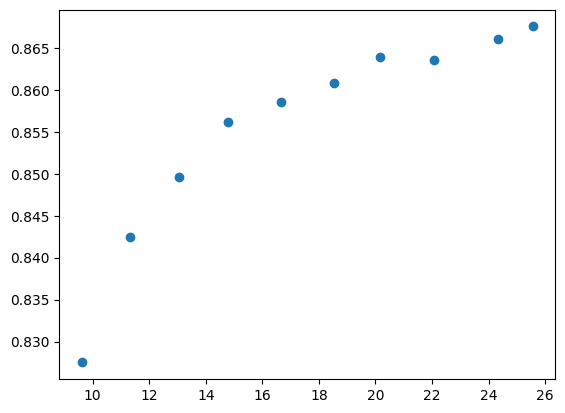

In [26]:
plt.scatter(times, oob_scores)

In [ ]:
param_grid = {
    "n_estimators": [100, 200],
    "max_features": ["log2", "sqrt"],
    "max_samples": [15000, 17000, 19000, 21000, 23000, 25000, 27000, 29000],
}

search = GridSearchCV(
    RandomForestClassifier(n_jobs=-1), param_grid, cv=2, scoring="accuracy"
)
search.fit(X, y)

GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'max_features': ['log2', 'sqrt'],
                         'max_samples': [15000, 17000, 19000, 21000, 23000,
                                         25000, 27000, 29000],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [36]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_samples,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.619154,0.081377,0.180445,0.015986,log2,2000,100,"{'max_features': 'log2', 'max_samples': 2000, ...",0.836600,0.838233,0.837417,0.000817,40
1,1.053228,0.015512,0.332963,0.026533,log2,2000,200,"{'max_features': 'log2', 'max_samples': 2000, ...",0.838233,0.837133,0.837683,0.000550,39
2,0.899306,0.040656,0.173548,0.003499,log2,4000,100,"{'max_features': 'log2', 'max_samples': 4000, ...",0.849700,0.846000,0.847850,0.001850,36
3,1.536810,0.016990,0.349290,0.001800,log2,4000,200,"{'max_features': 'log2', 'max_samples': 4000, ...",0.851533,0.848800,0.850167,0.001367,35
4,1.185222,0.056859,0.185166,0.006787,log2,6000,100,"{'max_features': 'log2', 'max_samples': 6000, ...",0.853200,0.853100,0.853150,0.000050,34
5,2.125158,0.022686,0.368092,0.003303,log2,6000,200,"{'max_features': 'log2', 'max_samples': 6000, ...",0.857067,0.855967,0.856517,0.000550,32
6,1.386455,0.004250,0.189210,0.002432,log2,8000,100,"{'max_features': 'log2', 'max_samples': 8000, ...",0.857433,0.856900,0.857167,0.000267,30
7,2.802780,0.086891,0.448475,0.004184,log2,8000,200,"{'max_features': 'log2', 'max_samples': 8000, ...",0.860833,0.859400,0.860117,0.000717,29
8,1.701066,0.012070,0.213621,0.007038,log2,10000,100,"{'max_features': 'log2', 'max_samples': 10000,...",0.861067,0.859800,0.860433,0.000633,27
9,3.226853,0.013404,0.427741,0.020138,log2,10000,200,"{'max_features': 'log2', 'max_samples': 10000,...",0.862167,0.860567,0.861367,0.000800,26


In [54]:
results = pd.DataFrame(search.cv_results_)

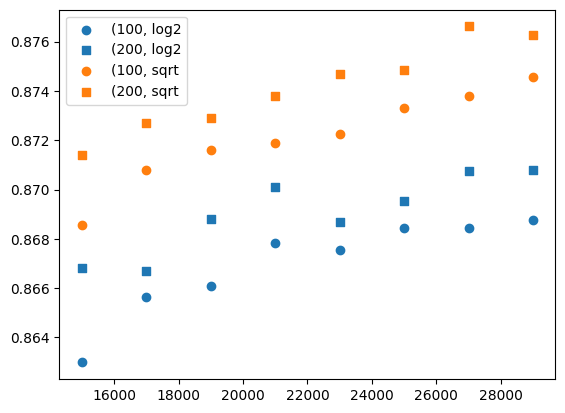

In [ ]:
for (max_features, n_estimators), group in results.groupby(
    ["param_max_features", "param_n_estimators"]
):
    plt.scatter(
        group["param_max_samples"],
        group["mean_test_score"],
        marker="o" if n_estimators == 100 else "s",
        c="C0" if max_features == "log2" else "C1",
        label=f"({n_estimators}, {max_features}",
    )
plt.legend()
plt.show()

In [ ]:
param_grid = {
    "n_estimators": [1000],
}

search = GridSearchCV(
    RandomForestClassifier(max_samples=27_000, max_features="sqrt", n_jobs=-1),
    param_grid,
    cv=2,
    scoring="accuracy",
)
search.fit(X, y)
results = pd.DataFrame(search.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,105.0292,0.263071,2.836606,0.204289,1000,{'n_estimators': 1000},0.8779,0.8772,0.87755,0.00035,1


$$
\begin{aligned}
\tilde{r}_i^2 &= (y_i - \tilde{f}(x_i))^2\\
&= (y_i - (f(x_i) +\epsilon r(x_i)))^2\\
&= (r_i - \epsilon(r_i + \eta_i))^2\\
&= ((1 - \epsilon)r_i - \epsilon\eta_i)^2
\end{aligned}
$$

$$
\begin{aligned}
\frac{\tilde{r}_i^2}{r_i^2} &= \left(1 - \epsilon\left(1+\frac{\eta_i}{r_i}\right)\right)^2
\end{aligned}
$$

Suppose
$$
\left|\frac{\eta_i}{r_i}\right| < 1 - \delta.
$$

Then
$$
1 + \frac{\eta_i}{r_i} > \delta.
$$

Therefore,
$$
1 - \epsilon\left(1+\frac{\eta_i}{r_i}\right) < 1 - \epsilon\delta
$$
and
$$
\frac{\tilde{r}_i^2}{r_i^2} < (1 - \epsilon\delta)^2.
$$
In particular,
$$
\tilde{r}_i^2 < r_i^2
$$
and we've reduced the training error.

Fit a ***residual model*** $r(x)$ to $(x_i, r_i)$, so that
$$
r(x_i)\approx r_i.
$$
Suppose that 

$$
\begin{aligned}
\tilde{r}_i^2 &= (y_i - \tilde{f}(x_i))^2\\
&= (y_i - (f(x_i) + r(x_i)))^2\\
&= \left(r_i - r(x_i)\right)^2
\end{aligned}
$$

$$
\begin{aligned}
\frac{\tilde{r}_i^2}{r_i^2} &= \left(1 - \left(1+\frac{\eta_i}{r_i}\right)\right)^2
\end{aligned}
$$

Suppose
$$
\left|\frac{\eta_i}{r_i}\right| < 1.
$$

Then
$$
1 + \frac{\eta_i}{r_i} > 0.
$$

Therefore,
$$
1 - \left(1+\frac{\eta_i}{r_i}\right) < 1
$$
and
$$
\frac{\tilde{r}_i^2}{r_i^2} < 1.
$$
In particular,
$$
\tilde{r}_i^2 < r_i^2
$$
and we've reduced the training error.

In [121]:
from sklearn.ensemble import GradientBoostingRegressor

df = pd.read_csv("data/auto_preprocessed.csv")
y = df.iloc[:, 0]
X = df.iloc[:, 1:]

In [ ]:
cross_val_score(
    GradientBoostingRegressor(n_estimators=700, learning_rate=0.02, max_features=2),
    X,
    y,
    scoring="neg_mean_squared_error",
).mean()

np.float64(-7.556189933196023)

In [134]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

$$
L(\hat{y}_0,\ldots,\hat{y}_{n-1}) = \frac1n\sum_i(y_i - \hat{y}_i)^2
$$

For small increments $h_0,\ldots,h_{n-1}$, we have the **first-order approximation**
$$
\begin{aligned}
L(\hat{y}_0 + h_0,\ldots, \hat{y}_{n-1} + h_{n-1}) - L(\hat{y})
&\approx \sum_{i < n}\frac{\partial L}{\partial \hat{y}_i}h_i\\
&= -\frac{2}{n}\sum_{i < n}(y_i - \hat{y_i})h.
\end{aligned}
$$

If $\varepsilon$ is a sufficiently small positive number, then
$$
h_i = \varepsilon (y_i -\hat{y}_i)
$$
is a small increment and
$$
L(\hat{y}_0 + h_0,\ldots, \hat{y}_{n-1} + h_{n-1}) - L(\hat{y}) \approx -\frac{2\epsilon}{n}\sum_{i < n}(y_i - \hat{y_i})^2 < 0.
$$
Thus,
$$
L(\hat{y}_0 + h_0,\ldots, \hat{y}_{n-1} + h_{n-1}) < L(\hat{y}).
$$

In [ ]:
y_pred = np.zeros_like(y)
r = y.copy()
for i in range(30):
    model = DecisionTreeRegressor(max_depth=3)
    model.fit(X, r)
    s = model.predict(X)
    print(np.mean(np.abs((s - r) / r) < 1))
    y_pred += s if i == 0 else 0.3 * s
    print(mean_squared_error(y, y_pred))
    r -= s

1.0
10.432337988446655
0.6025641025641025
8.657564059408113
0.5333333333333333
8.28220521133322
0.5435897435897435
7.932995345221081
0.5435897435897435
7.504059866981435
0.5435897435897435
7.355108906508492
0.5333333333333333
7.2306625184391
0.5487179487179488
7.065296008334797
0.5205128205128206
6.881755902718861
0.5461538461538461
6.713301499976998
0.5230769230769231
6.695194018197012
0.49743589743589745
6.629563090588511
0.5205128205128206
6.577122320437716
0.5538461538461539
6.421397941262739
0.5384615384615384
6.227279981572946
0.5256410256410257
6.083838752969379
0.5153846153846153
6.100285933143115
0.5282051282051282
6.004985177477861
0.5025641025641026
5.992204284893995
0.5256410256410257
5.881007165439097
0.5282051282051282
5.817922798752009
0.5102564102564102
5.778663545240203
0.5205128205128206
5.754471737240166
0.517948717948718
5.759138948188842
0.5153846153846153
5.770281425932647
0.5153846153846153
5.742462661542683
0.558974358974359
5.666438135050437
0.5153846153846153


In [133]:
from sklearn.ensemble import GradientBoostingRegressor

df = pd.read_csv("data/auto_preprocessed.csv")
y = df.iloc[:, 0]
X = df.iloc[:, 1:]

model = DecisionTreeRegressor(min_samples_leaf=20, max_depth=5)
model.fit(X, y)
r = y - model.predict(X)
r.mean()

np.float64(-7.651998692801079e-16)

In [113]:
model2 = DecisionTreeRegressor(max_depth=1)
model2.fit(X, r1)
print(mean_squared_error(y, model0.predict(X) + model1.predict(X) + model2.predict(X)))
r2 = r1 - model2.predict(X)

16.260552689699413


In [148]:
import mlflow

In [151]:
mlflow.login()

2025/03/13 15:29:03 INFO mlflow.utils.credentials: No valid Databricks credentials found, please enter your credentials...
2025/03/13 15:29:44 INFO mlflow.utils.credentials: Successfully connected to MLflow hosted tracking server! Host: https://dbc-906fdf3d-2ae6.cloud.databricks.com.


In [152]:
mlflow.set_tracking_uri("databricks")

In [153]:
mlflow.create_experiment(
    "/Users/fmgreenberg@gmail.com/check-databricks-connection",
    artifact_location="dbfs:/Volumes/test/mlflow/check-databricks-connection",
)
mlflow.set_experiment("/Users/fmgreenberg@gmail.com/check-databricks-connection")

with mlflow.start_run():
    mlflow.log_metric("foo", 1)
    mlflow.log_metric("bar", 2)

🏃 View run bald-asp-633 at: https://dbc-906fdf3d-2ae6.cloud.databricks.com/ml/experiments/3952425434651851/runs/5b8bad2eb2ae4f1bbb69ecc9bff231c6
🧪 View experiment at: https://dbc-906fdf3d-2ae6.cloud.databricks.com/ml/experiments/3952425434651851


In [53]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv("data/auto_preprocessed.csv")

y = df.iloc[:, 0]
X = df.iloc[:, 1:]

f = make_pipeline(PolynomialFeatures(degree=3), StandardScaler(), Ridge(alpha=0.085))
cross_val_score(f, X, y, scoring="neg_mean_squared_error", cv=RepeatedKFold()).mean()

np.float64(-7.589812815537471)

In [266]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
f.fit(X_train, y_train)

rng = np.random.default_rng(42)
e_train = rng.normal(scale=2.7, size=len(X_train))
e_test = rng.normal(scale=2.7, size=len(X_test))

y_train = pd.Series(f.predict(X_train) + e_train, index=X_train.index, name="y_train")
y_test = pd.Series(f.predict(X_test) + e_test, index=X_test.index, name="y_test")

In [267]:
n_estimators = 100
rf = RandomForestRegressor(n_estimators=n_estimators)
rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

10.588148274435854

In [268]:
fs = f.predict(X_test)

In [269]:
fhats = np.zeros((n_estimators, len(X_test)))
for i, fhat in enumerate(rf.estimators_):
    fhats[i] = fhat.predict(X_test.to_numpy())

In [270]:
rf.predict(X_test)

array([29.16106345, 25.19956939, 22.89637899, 15.72000696, 13.88831509,
       25.34475134, 14.19617436, 17.91169786, 20.91040928, 18.25211938,
       30.73557966, 13.07960933, 25.5505433 , 32.57103001, 25.00255312,
       37.79954009, 29.02371998, 13.42613792, 14.2232039 , 16.36339136,
       25.53387125, 29.62402786, 17.2684339 , 26.56700154, 39.37430656,
       20.26643434, 36.3853484 , 18.53962654, 26.77665966, 14.29810888,
       29.0074909 , 17.37710157, 26.89521534, 31.44287397, 38.28204976,
       27.04415525, 39.69779925, 34.40410169, 20.16468946, 29.90113042,
       23.89647558, 34.56477451, 32.8012163 , 17.3781436 , 23.7067349 ,
       14.10743819, 30.05443333, 33.44888333, 27.17532359, 15.62289222,
       23.91630796, 15.73725589, 19.68702068, 17.79215796, 24.64096611,
       25.25446363, 12.8626834 , 21.53794021, 14.51238779, 14.11858512,
       25.83319433, 30.44760818, 32.05434004, 24.13115147, 30.19830665,
       18.07357197, 22.86815457, 33.24638953, 32.84522997, 17.07

In [271]:
np.sqrt(7.5)

np.float64(2.7386127875258306)

In [272]:
np.mean(fhats - fs, axis=0)

array([-0.83256928, -0.68254559,  0.32981316, -1.76960547, -0.03789812,
        0.44516415,  0.11047831,  2.22166224,  0.96419552,  0.13272421,
        0.39215961, -0.58059601, -0.00886976, -1.76676689, -0.16282118,
        1.41834282, -0.65923744, -0.02914673,  1.05669373,  1.7617907 ,
        1.55177134,  0.5730318 ,  1.87592407, -1.17492684,  2.55022859,
        0.93929784,  0.0890598 , -0.82438404, -0.83943368,  0.64054771,
       -0.84439623,  0.50954081, -3.21593262, -1.24866154, -0.35981619,
       -6.30171216,  1.07690131, -1.90819879,  0.991747  , -0.86011113,
        1.81838064, -1.367904  ,  0.74231967, -2.68266095, -2.84280163,
        0.50788909, -0.45259393,  0.76519577,  0.2848758 ,  0.34131511,
        1.49924182, -0.16630811,  0.80415968,  2.57844704,  0.97416931,
       -4.99691834, -0.01017327,  1.05553357, -0.03548538, -0.58239346,
       -0.52907603, -1.59194544,  0.44776022,  0.80663765,  0.05585716,
       -0.4494918 , -3.0550109 , -2.22077532,  0.36169352,  1.33

In [273]:
y_test - (fhats.mean(axis=0) + np.mean(fs - fhats, axis=0) + e_test)

326    0.000000e+00
50    -1.776357e-14
14     7.105427e-15
290   -1.065814e-14
40    -1.776357e-15
           ...     
149    1.065814e-14
130   -3.552714e-15
375    2.131628e-14
286    0.000000e+00
70     0.000000e+00
Name: y_test, Length: 78, dtype: float64

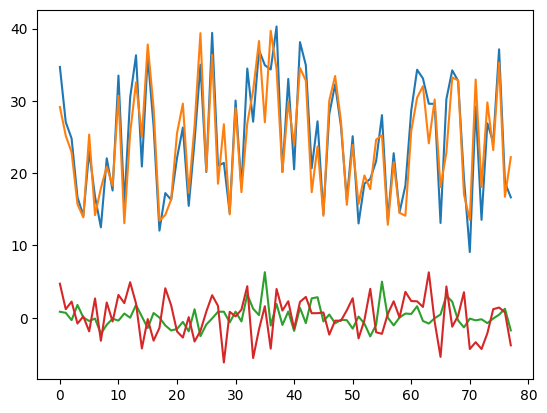

In [274]:
plt.plot(y_test.to_numpy())
plt.plot(fhats.mean(axis=0))
plt.plot(np.mean(fs - fhats, axis=0))
plt.plot(e_test)

In [ ]:
np.mean(e_test * np.mean(fs - fhats, axis=0))

np.float64(0.348900991223792)

In [ ]:
def f(x):
    return (
        -0.002205 * x + 0.0462 * x**2 - 0.338 * x**3 + 1.13 * x**4 - 1.75 * x**5 + x**6
    )

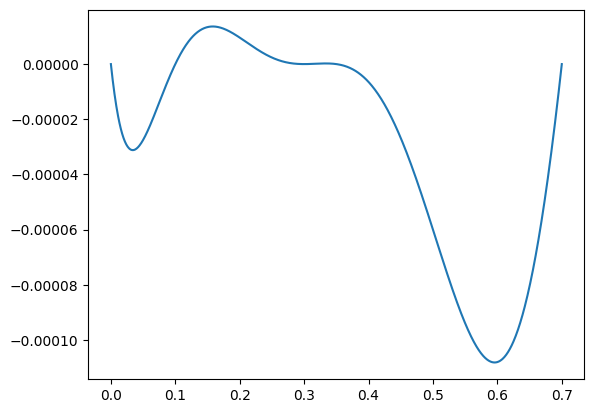

In [ ]:
x = np.linspace(0, 0.7, 1000)
plt.plot(x, (1 - x) ** 2 * f(x))

In [13]:
c = np.array([0, -0.002205, 0.0462, -0.338, +1.13, -1.75, 1, 0, 0])

(-0.5, 1.5)

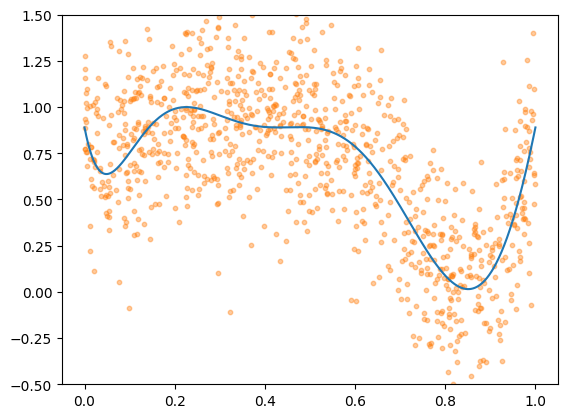

In [ ]:
def f(x):
    c = np.array(
        [
            8.89790000e-01,
            -1.24853715e01,
            2.00598302e02,
            -1.20027425e03,
            3.59728524e03,
            -5.91118526e03,
            5.35786134e03,
            -2.49811475e03,
            4.66314753e02,
        ]
    )
    return sum(ci * x**i for i, ci in enumerate(c))


n = 1000
sigma = 0.1
n_estimators = 10000

rng = np.random.default_rng()
x_train = rng.uniform(size=n)
e_train = rng.normal(scale=0.3, size=n)
y_train = f(x_train) + e_train

x_test = np.linspace(0, 1, 1000)
X_test = x_test.reshape(-1, 1)
e_test = rng.normal(scale=0.3, size=n)
y_test = f(x_test) + e_train

plt.plot(x_test, f(x_test))
plt.scatter(x_train, y_train, s=10, c="C1", alpha=0.4)
plt.ylim(-0.5, 1.5)

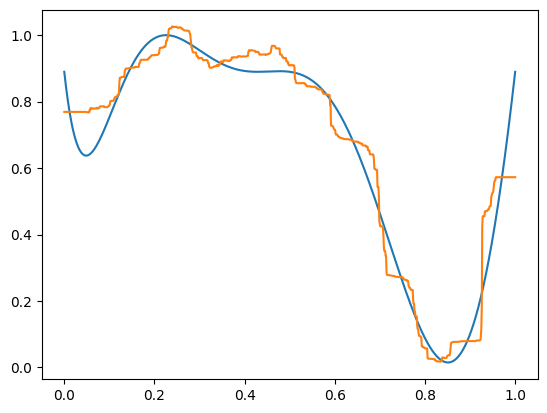

In [ ]:
model = GridSearchCV(
    RandomForestRegressor(n_estimators=2000),
    param_grid={"min_samples_leaf": np.arange(30, 45)},
    scoring="neg_mean_squared_error",
)
model.fit(x_train.reshape(-1, 1), y_train)
plt.plot(x_test, f(x_test))
plt.plot(x_test, model.predict(x_test.reshape(-1, 1)))

ic| model.best_params_: {'min_samples_leaf': np.int64(39)}


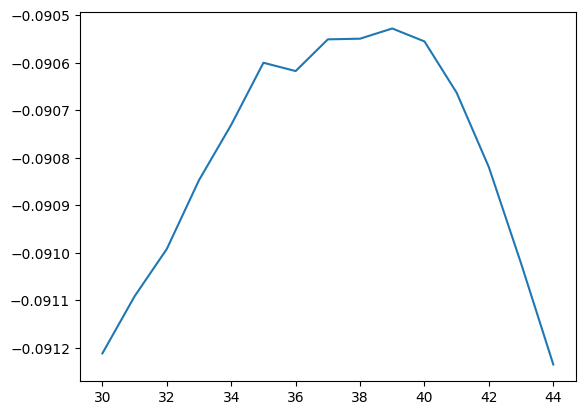

In [210]:
ic(model.best_params_)
plt.plot(
    model.cv_results_["param_min_samples_leaf"],
    model.cv_results_["mean_test_score"],
)

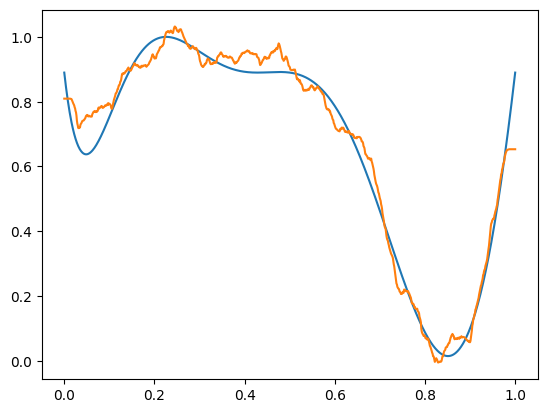

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor

model = GridSearchCV(
    BaggingRegressor(KNeighborsRegressor(), n_estimators=100),
    param_grid={"estimator__n_neighbors": np.arange(30, 60)},
    scoring="neg_mean_squared_error",
    cv=RepeatedKFold(),
)
model.fit(x_train.reshape(-1, 1), y_train)
plt.plot(x_test, f(x_test))
plt.plot(x_test, model.predict(x_test.reshape(-1, 1)))

In [205]:
model.best_params_

{'estimator__n_neighbors': np.int64(44)}

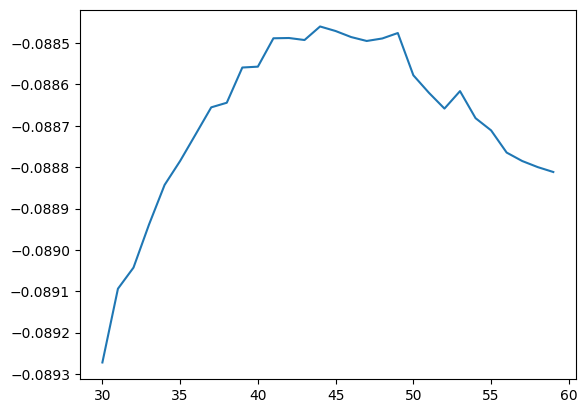

In [ ]:
plt.plot(
    model.cv_results_["param_estimator__n_neighbors"],
    model.cv_results_["mean_test_score"],
)

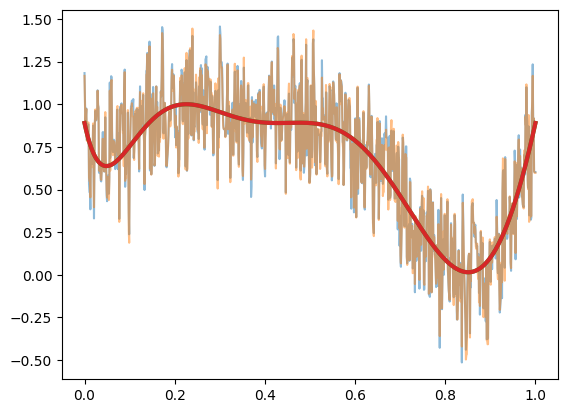

In [216]:
model = BaggingRegressor(KNeighborsRegressor(n_neighbors=1), n_estimators=100)
model.fit(x_train.reshape(-1, 1), y_train)
plt.plot(x_test, model.predict(x_test.reshape(-1, 1)), alpha=0.5)

model = RandomForestRegressor()
model.fit(x_train.reshape(-1, 1), y_train)
plt.plot(x_test, model.predict(x_test.reshape(-1, 1)), alpha=0.5)
plt.plot(x_test, f(x_test), lw=3)


plt.plot(x_test, f(x_test), lw=3)

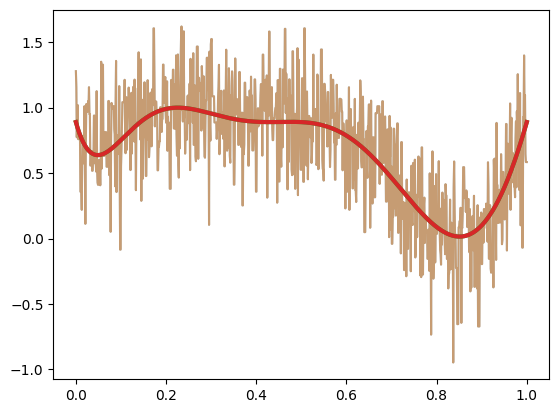

In [226]:
from sklearn.tree import DecisionTreeRegressor

model = KNeighborsRegressor(n_neighbors=1)
model.fit(x_train.reshape(-1, 1), y_train)
plt.plot(x_test, model.predict(x_test.reshape(-1, 1)), alpha=0.5)

model = DecisionTreeRegressor(min_samples_leaf=1)
model.fit(x_train.reshape(-1, 1), y_train)
plt.plot(x_test, model.predict(x_test.reshape(-1, 1)), alpha=0.5)
plt.plot(x_test, f(x_test), lw=3)


plt.plot(x_test, f(x_test), lw=3)

(-0.5, 1.5)

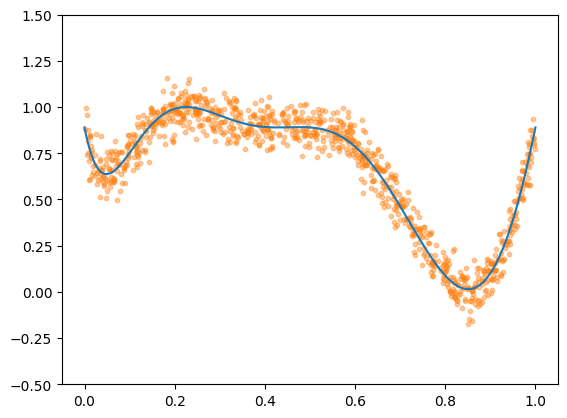

In [231]:
n = 1000
scale = 0.07
n_estimators = 10000

rng = np.random.default_rng()
x_train = rng.uniform(size=n)
e_train = rng.normal(scale=scale, size=n)
y_train = f(x_train) + e_train

x_test = np.linspace(0, 1, 1000)
X_test = x_test.reshape(-1, 1)
e_test = rng.normal(scale=scale, size=n)
y_test = f(x_test) + e_train

plt.plot(x_test, f(x_test))
plt.scatter(x_train, y_train, s=10, c="C1", alpha=0.4)
plt.ylim(-0.5, 1.5)

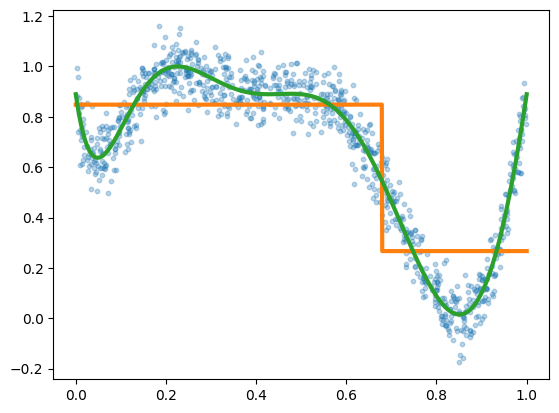

In [240]:
X_train = x_train.reshape(-1, 1)
X_test = x_test.reshape(-1, 1)

model = DecisionTreeRegressor(max_depth=1)
model.fit(X_train, y_train)
plt.scatter(x_train, y_train, s=10, c="C0", alpha=0.3)
plt.plot(x_test, model.predict(X_test), "C1", lw=3)
plt.plot(x_test, f(x_test), "C2", lw=3)

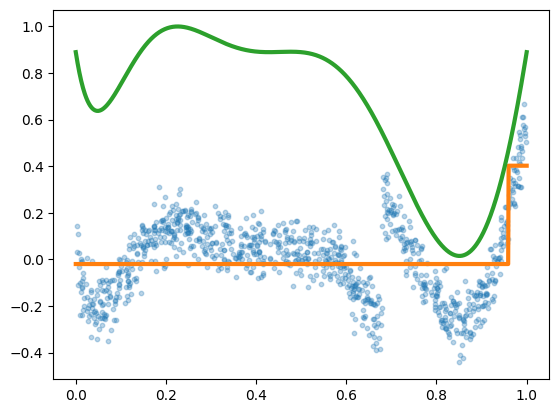

In [246]:
model1 = DecisionTreeRegressor(max_depth=1)
model1.fit(X_train, y_train - model.predict(X_train))


plt.scatter(x_train, y_train - model.predict(X_train), s=10, c="C0", alpha=0.3)
plt.plot(x_test, model1.predict(X_test), "C1", lw=3)
plt.plot(x_test, f(x_test), "C2", lw=3)

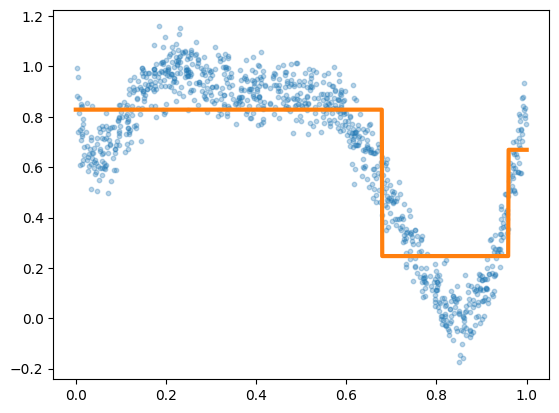

In [247]:
plt.scatter(x_train, y_train, s=10, c="C0", alpha=0.3)
plt.plot(x_test, model.predict(X_test) + model1.predict(X_test), "C1", lw=3)

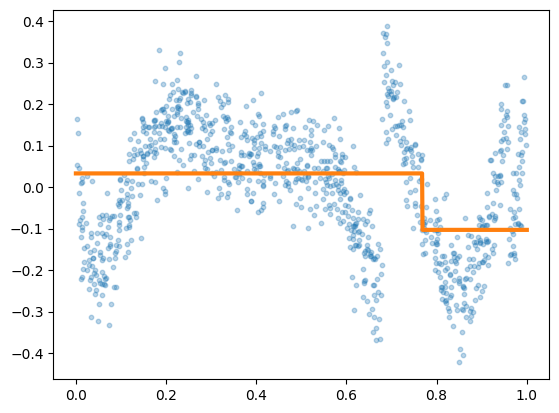

In [ ]:
model2 = DecisionTreeRegressor(max_depth=1)
model2.fit(X_train, y_train - model.predict(X_train) - model1.predict(X_train))


plt.scatter(
    x_train,
    y_train - model.predict(X_train) - model1.predict(X_train),
    s=10,
    c="C0",
    alpha=0.3,
)
plt.plot(x_test, model2.predict(X_test), "C1", lw=3)

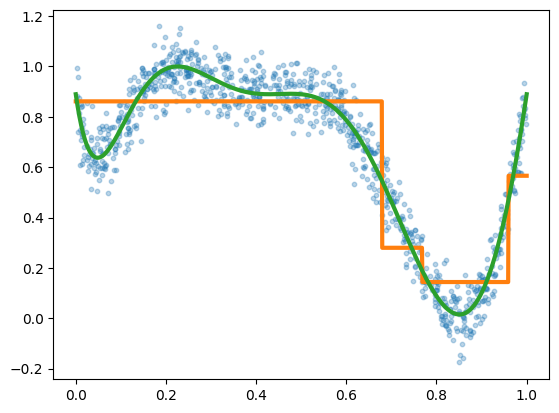

In [ ]:
plt.scatter(x_train, y_train, s=10, c="C0", alpha=0.3)
plt.plot(
    x_test,
    model.predict(X_test) + model1.predict(X_test) + model2.predict(X_test),
    "C1",
    lw=3,
)
plt.plot(x_test, f(x_test), "C2", lw=3)

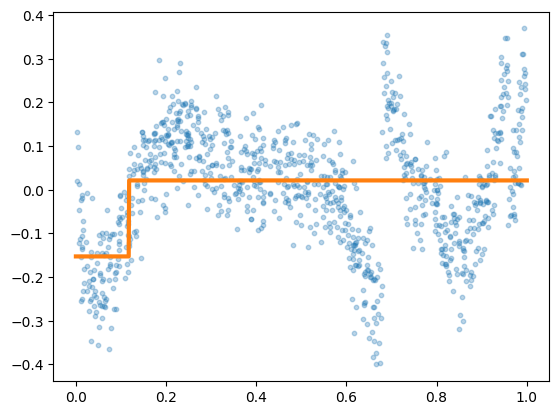

In [250]:
model3 = DecisionTreeRegressor(max_depth=1)
model3.fit(
    X_train,
    y_train
    - model.predict(X_train)
    - model1.predict(X_train)
    - model2.predict(X_train),
)


plt.scatter(
    x_train,
    y_train
    - model.predict(X_train)
    - model1.predict(X_train)
    - model2.predict(X_train),
    s=10,
    c="C0",
    alpha=0.3,
)
plt.plot(x_test, model3.predict(X_test), "C1", lw=3)

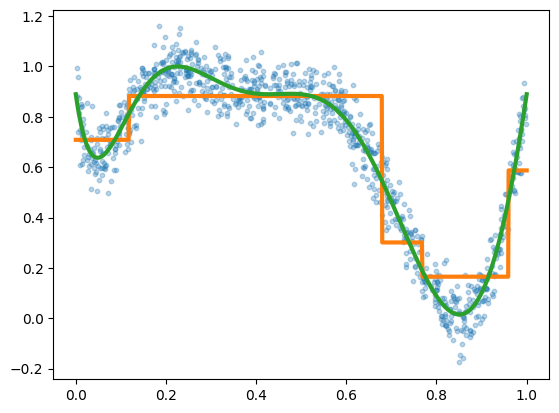

In [251]:
plt.scatter(x_train, y_train, s=10, c="C0", alpha=0.3)
plt.plot(
    x_test,
    model.predict(X_test)
    + model1.predict(X_test)
    + model2.predict(X_test)
    + model3.predict(X_test),
    "C1",
    lw=3,
)
plt.plot(x_test, f(x_test), "C2", lw=3)

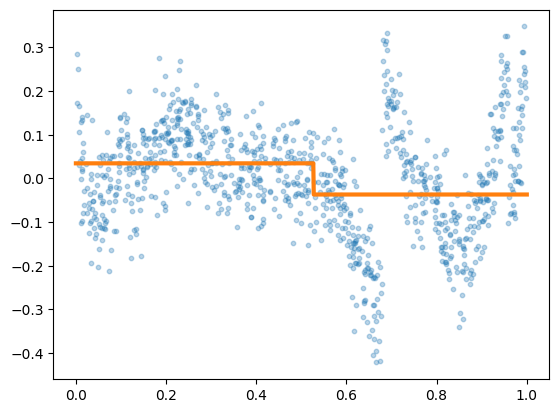

In [253]:
model4 = DecisionTreeRegressor(max_depth=1)
model4.fit(
    X_train,
    y_train
    - model.predict(X_train)
    - model1.predict(X_train)
    - model2.predict(X_train)
    - model3.predict(X_train),
)


plt.scatter(
    x_train,
    y_train
    - model.predict(X_train)
    - model1.predict(X_train)
    - model2.predict(X_train)
    - model3.predict(X_train),
    s=10,
    c="C0",
    alpha=0.3,
)
plt.plot(x_test, model4.predict(X_test), "C1", lw=3)

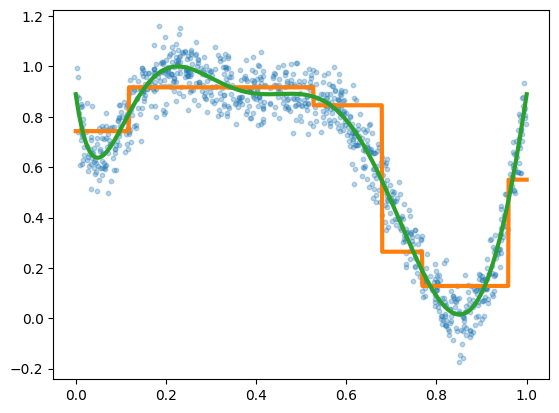

In [254]:
plt.scatter(x_train, y_train, s=10, c="C0", alpha=0.3)
plt.plot(
    x_test,
    model.predict(X_test)
    + model1.predict(X_test)
    + model2.predict(X_test)
    + model3.predict(X_test)
    + model4.predict(X_test),
    "C1",
    lw=3,
)
plt.plot(x_test, f(x_test), "C2", lw=3)

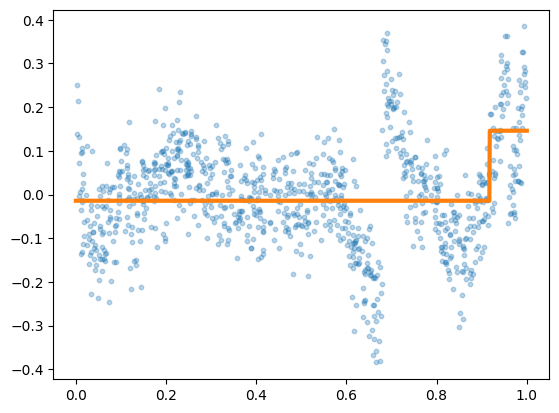

In [256]:
model5 = DecisionTreeRegressor(max_depth=1)
model5.fit(
    X_train,
    y_train
    - model.predict(X_train)
    - model1.predict(X_train)
    - model2.predict(X_train)
    - model3.predict(X_train)
    - model4.predict(X_train),
)


plt.scatter(
    x_train,
    y_train
    - model.predict(X_train)
    - model1.predict(X_train)
    - model2.predict(X_train)
    - model3.predict(X_train)
    - model4.predict(X_train),
    s=10,
    c="C0",
    alpha=0.3,
)
plt.plot(x_test, model5.predict(X_test), "C1", lw=3)

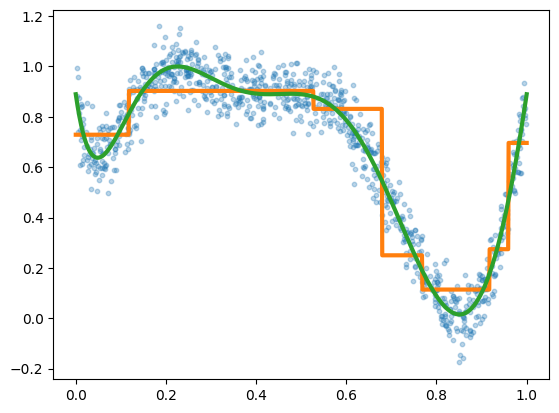

In [257]:
plt.scatter(x_train, y_train, s=10, c="C0", alpha=0.3)
plt.plot(
    x_test,
    model.predict(X_test)
    + model1.predict(X_test)
    + model2.predict(X_test)
    + model3.predict(X_test)
    + model4.predict(X_test)
    + model5.predict(X_test),
    "C1",
    lw=3,
)
plt.plot(x_test, f(x_test), "C2", lw=3)

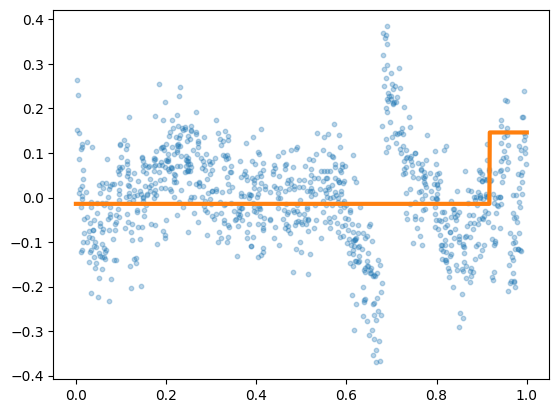

In [258]:
model6 = DecisionTreeRegressor(max_depth=1)
model6.fit(
    X_train,
    y_train
    - model.predict(X_train)
    - model1.predict(X_train)
    - model2.predict(X_train)
    - model3.predict(X_train)
    - model4.predict(X_train),
)


plt.scatter(
    x_train,
    y_train
    - model.predict(X_train)
    - model1.predict(X_train)
    - model2.predict(X_train)
    - model3.predict(X_train)
    - model4.predict(X_train)
    - model5.predict(X_train),
    s=10,
    c="C0",
    alpha=0.3,
)
plt.plot(x_test, model6.predict(X_test), "C1", lw=3)

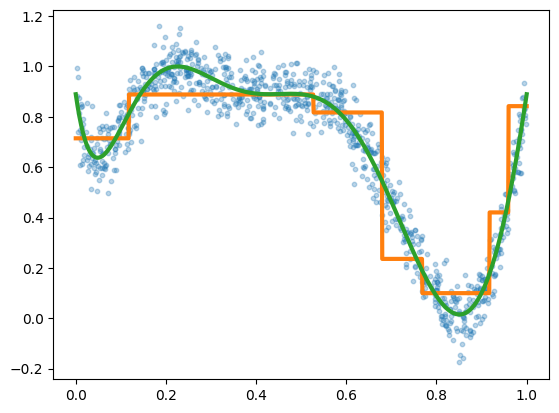

In [259]:
plt.scatter(x_train, y_train, s=10, c="C0", alpha=0.3)
plt.plot(
    x_test,
    model.predict(X_test)
    + model1.predict(X_test)
    + model2.predict(X_test)
    + model3.predict(X_test)
    + model4.predict(X_test)
    + model5.predict(X_test)
    + model6.predict(X_test),
    "C1",
    lw=3,
)
plt.plot(x_test, f(x_test), "C2", lw=3)

In [315]:
r = y_train.copy()
models = []
for i in range(150):
    model = DecisionTreeRegressor(max_depth=1)
    models.append(model)
    model.fit(X_train, r)
    r -= model.predict(X_train)

In [316]:
preds = np.cumsum(np.array([model.predict(X_test) for model in models]), axis=0)

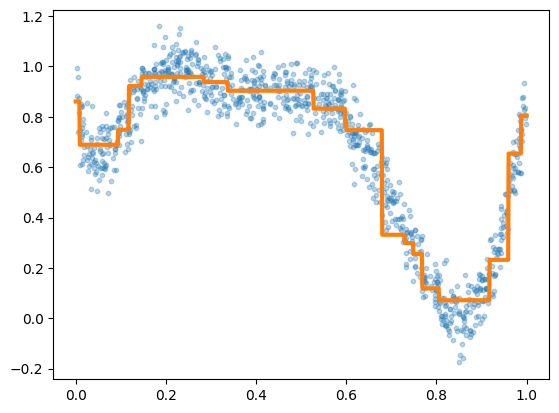

In [317]:
plt.scatter(x_train, y_train, s=10, c="C0", alpha=0.3)
# for i in range(20):
#     plt.plot(x_test, preds[i], "C1", lw=3, alpha=1/(20 - i))
plt.plot(x_test, preds[20], "C1", lw=3)

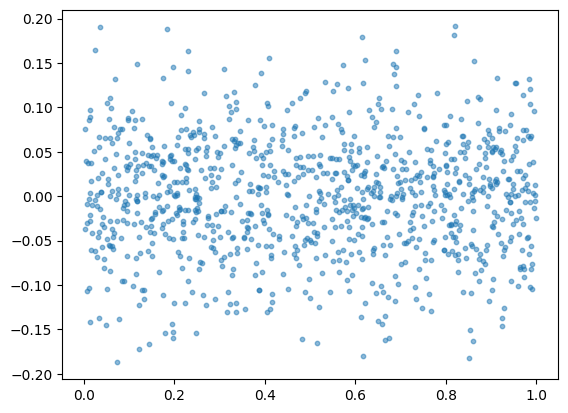

In [322]:
plt.scatter(x_train, r, s=10, c="C0", alpha=0.5)

In [326]:
df = pd.read_csv("data/auto_preprocessed.csv")
df.head()
y = df.iloc[:, 0]
X = df.iloc[:, 1:]

In [341]:
param_grid = {"min_samples_leaf": [1, 2]}
model = GridSearchCV(
    RandomForestRegressor(n_estimators=500),
    param_grid,
    scoring="neg_mean_squared_error",
    cv=RepeatedKFold(),
)
model.fit(X, y)

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=None),
             estimator=RandomForestRegressor(n_estimators=500),
             param_grid={'min_samples_leaf': [1, 2]},
             scoring='neg_mean_squared_error')

In [342]:
model.best_params_

{'min_samples_leaf': 1}

In [343]:
model.best_score_

np.float64(-7.771959498246162)

In [344]:
pd.DataFrame(model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
0,0.361460,0.013235,0.015549,0.004765,1,{'min_samples_leaf': 1},-4.324463,-5.578400,-5.416986,-10.119462,...,-7.527680,-10.010459,-7.210078,-6.058875,-7.316266,-14.108243,-4.707988,-7.771959,2.258091,1
1,0.322235,0.004880,0.014230,0.000333,2,{'min_samples_leaf': 2},-4.214140,-6.287169,-5.485191,-10.295634,...,-7.926774,-10.091152,-7.655192,-6.308727,-7.661630,-14.104097,-4.325740,-7.865334,2.249518,2


In [345]:
X_train = x_train.reshape(-1, 1)
X_test = x_test.reshape(-1, 1)

In [ ]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
max_depths = [e.tree_.max_depth for e in model.estimators_]
node_counts = [e.tree_.node_count for e in model.estimators_]
n_leaves = [e.tree_.n_leaves for e in model.estimators_]
ic(np.median(max_depths), np.median(node_counts), np.median(n_leaves))

ic| np.median(max_depths): np.float64(24.0)
    np.median(node_counts): np.float64(1259.0)
    np.median(n_leaves): np.float64(630.0)


In [1]:
from sklearn.datasets import fetch_california_housing

In [ ]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
from sklearn.ensemble import RandomForestRegressor

model = model = GridSearchCV(
    RandomForestRegressor(n_jobs=-1), param_grid={}, scoring="neg_mean_squared_error"
)
model.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1), param_grid={},
             scoring='neg_mean_squared_error')

In [38]:
from sklearn.ensemble import HistGradientBoostingRegressor

model = model = GridSearchCV(
    HistGradientBoostingRegressor(max_iter=200),
    param_grid={"learning_rate": [0.01, 0.1, 1.0]},
    scoring="neg_mean_squared_error",
)
model.fit(X_train, y_train)

GridSearchCV(estimator=HistGradientBoostingRegressor(max_iter=200),
             param_grid={'learning_rate': [0.01, 0.1, 1.0]},
             scoring='neg_mean_squared_error')

In [39]:
model.best_score_

np.float64(-0.2146666498239617)

In [40]:
model.best_params_

{'learning_rate': 0.1}

In [69]:
from lightgbm import LGBMRegressor

model = model = GridSearchCV(
    LGBMRegressor(n_estimators=300, learning_rate=0.157),
    {},
    scoring="neg_mean_squared_error",
)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 13209, number of used features: 8
[LightGBM] [Info] Start training from score 2.057723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 13209, number of used features: 8
[LightGBM] [Info] Start training from score 2.070247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 13210, number of used features: 8
[LightGBM] [Info] Start traini

GridSearchCV(estimator=LGBMRegressor(learning_rate=0.157, n_estimators=300),
             param_grid={}, scoring='neg_mean_squared_error')

In [70]:
model.best_score_

np.float64(-0.20755257372728156)